In [6]:
import numpy as np
import cupy as cp # run in GPU
from scipy.linalg import hadamard
import pickle
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt

In [7]:
class BroadHashing:
    def __init__(self, num_classes, hash_bits, 
                 num_feature_groups=10, nodes_per_group=100, 
                 num_enhancement=1000, lambda_reg=1e-6):
        """
        Broad Hashing for Image Retrieval
        
        Parameters:
        -----------
        num_classes : int
            Number of classes in dataset
        hash_bits : int
            Length of binary hash codes (32 or 64)
        num_feature_groups : int
            Number of feature mapping groups (a in paper)
        nodes_per_group : int
            Number of nodes per feature group (α in paper)
        num_enhancement : int
            Number of enhancement nodes (c in paper)
        lambda_reg : float
            Regularization parameter (default 2**-27 as per anchor paper)
        """
        self.l = num_classes
        self.r = hash_bits
        self.a = num_feature_groups
        self.alpha = nodes_per_group
        self.c = num_enhancement
        self.lambda_reg = lambda_reg
        
        # Store weights for prediction
        self.W_s_list = []
        self.beta_s_list = []
        self.W_e_list = []
        self.beta_e_list = []
        
    def _generate_hadamard_codes(self):
        """Generate hash code table using Hadamard matrix"""
        from scipy.linalg import hadamard
        
        # Find smallest power of 2 >= num_classes
        r_full = 2 ** int(np.ceil(np.log2(self.l)))
        H_r = cp.asarray(hadamard(r_full))
        
        # Sample l rows and take first r columns
        if self.r < r_full:
            H_r = H_r[:, :self.r]
        
        indices = cp.random.choice(r_full, self.l, replace=False)
        H_l = H_r[indices]
        
        return H_l
    
    def _create_feature_layer(self, X):
        """Create shallow-mapped feature layer"""
        n, d = X.shape
        S_list = []
        
        print(f"    Creating {self.a} feature groups × {self.alpha} nodes...")
        
        for i in range(self.a):
            # Random weights and bias
            W_si = cp.random.randn(d, self.alpha) * 0.1
            beta_si = cp.random.randn(1, self.alpha) * 0.1
            
            # Store for prediction
            if len(self.W_s_list) < self.a:
                self.W_s_list.append(W_si)
                self.beta_s_list.append(beta_si)
            
            # Compute S_i = tanh(X·W + β)
            S_i = cp.tanh(X @ W_si + beta_si)
            S_list.append(S_i)
        
        # Concatenate all feature groups (pseudocode line 8)
        S_a = cp.hstack(S_list)
        total_feature_nodes = self.a * self.alpha
        print(f" Total feature nodes: {total_feature_nodes}")
        
        return S_a
    
    def _create_enhancement_layer(self, S_a):
        """Create enhancement layer"""
        print(f"    Creating {self.c} enhancement nodes...")
        
        E_list = []
        
        for j in range(self.c):
            # Random weights and bias
            W_ej = cp.random.randn(S_a.shape[1], 1) * 0.1
            beta_ej = cp.random.randn(1, 1) * 0.1
            
            # Store for prediction
            if len(self.W_e_list) < self.c:
                self.W_e_list.append(W_ej)
                self.beta_e_list.append(beta_ej)
            
            # Compute E_j = tanh(S·W + β)
            E_j = cp.tanh(S_a @ W_ej + beta_ej)
            E_list.append(E_j)
        
        # Concatenate all enhancement nodes
        E_c = cp.hstack(E_list)
        print(f" Total enhancement nodes: {self.c}")
        
        return E_c
    
    def fit(self, X, y):
        """
        Train BH model - Algorithm 1 from paper

        """
        X = cp.asarray(X, dtype=cp.float32)
        y = cp.asarray(y, dtype=cp.int32)
        print(f"\n  [Training BH Model]")
        print(f"    Training samples: {X.shape[0]}")
        print(f"    Feature dimension: {X.shape[1]}")
        
        # Step 1-2: Generate Hadamard hash code table
        print(f"    Generating {self.r}-bit Hadamard codes for {self.l} classes...")
        self.H_l = self._generate_hadamard_codes()
        print(f"    ✓ Hash code table: {self.H_l.shape}")
        
        # Step 4-8: Build shallow-mapped layer
        S_a = self._create_feature_layer(X)
        
        # Step 9-13: Build enhancement layer
        E_c = self._create_enhancement_layer(S_a)
        
        # Step 14: Full feature layer F = [S^a | E^c]
        F = cp.hstack([S_a, E_c])
        print(f"    Full feature layer: {F.shape}")
        
        # Step 15: Assign hash codes based on labels
        U = self.H_l[y]  # Map each sample to its class hash code
        
        # Step 16: Calculate W_h via ridge regression (Eq. 9)
        print(f"    Solving ridge regression...")
        lambda_I = self.lambda_reg * cp.eye(F.shape[1])
        
        # W_h = (λI + F^T·F)^(-1) · F^T · U
        try:
            self.W_h = cp.linalg.solve(lambda_I + F.T @ F, F.T @ U)
            print(f"   Hash weights: {self.W_h.shape}")
        except cp.linalg.LinAlgError:
            print("    Using pseudoinverse (matrix singular)...")
            self.W_h = cp.linalg.pinv(F) @ U
        
        return self
    
    def predict(self, X):
        """
        Generate hash codes for query images
        
        Parameters:
        -----------
        X : numpy array (n_samples, n_features)
            Query images
            
        Returns:
        --------
        B : numpy array (n_samples, hash_bits)
            Binary hash codes {-1, +1}
        """
        X = cp.asarray(X, dtype=cp.float32)
        # Recreate feature layer with stored weights
        S_list = []
        for i in range(self.a):
            S_i = cp.tanh(X @ self.W_s_list[i] + self.beta_s_list[i])
            S_list.append(S_i)
        S_a = cp.hstack(S_list)
        
        # Recreate enhancement layer with stored weights
        E_list = []
        for j in range(self.c):
            E_j = cp.tanh(S_a @ self.W_e_list[j] + self.beta_e_list[j])
            E_list.append(E_j)
        E_c = cp.hstack(E_list)
        
        # Full feature layer
        F = cp.hstack([S_a, E_c])
        
        # Generate binary codes: B = sign(F · W_h)
        B = cp.sign(F @ self.W_h)
        
        return B

In [8]:
# 2. LSH Baseline 

class LSH:
    """
    Locality Sensitive Hashing (Random Projection)
    Used as a baseline to prove BH learns semantic structure.
    """
    def __init__(self, hash_bits, input_dim):
        self.hash_bits = hash_bits
        self.input_dim = input_dim
        # Random projection matrix (Gaussian distribution)
        # We perform W * X, so shape is (input_dim, hash_bits)
        self.W = cp.random.randn(input_dim, hash_bits)
        
    def predict(self, X):
        """
        Project data and sign: B = sign(X @ W)
        """
        X = cp.asarray(X, dtype=cp.float32)
        # Simple random projection
        B = cp.sign(X @ self.W)
        return B

In [9]:
# 3. Helpers & Evaluation

def load_cifar10_local(data_dir):
    """Load CIFAR-10 from local directory"""
    def unpickle(file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    X_train_batches = []
    y_train_batches = []
    
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        batch_dict = unpickle(batch_file)
        X_train_batches.append(batch_dict[b'data'])
        y_train_batches.append(batch_dict[b'labels'])
    
    X_train = np.vstack(X_train_batches)
    y_train = np.hstack(y_train_batches)
    
    test_file = os.path.join(data_dir, 'test_batch')
    test_dict = unpickle(test_file)
    X_test = test_dict[b'data']
    y_test = np.array(test_dict[b'labels'])
    
    return X_train, y_train, X_test, y_test

# Evaluation Functions
def evaluate_retrieval(B_database, y_database, B_query, y_query, k_values=[10, 50, 100]):
    B_database = cp.array(B_database)
    y_database = cp.array(y_database)
    B_query = cp.array(B_query)
    y_query = cp.array(y_query)
    
    num_queries = B_query.shape[0]
    avg_precisions = []
    precisions_at_k = {k: [] for k in k_values}
    
    print(f"    Evaluating {num_queries} queries on GPU...")
    
    for i in range(num_queries):
        # 1. Hamming distance on GPU
        # Hamming distance: XOR
        distances = cp.count_nonzero(B_database != B_query[i:i+1], axis=1)
        
        # 2. Sort on GPU
        sorted_indices = cp.argsort(distances)
        
        # 3. Get labels on GPU
        retrieved_labels = y_database[sorted_indices]
        relevant = (retrieved_labels == y_query[i]).astype(cp.int32)
        
        # 4. Compute AP
        num_relevant = cp.sum(relevant)
        if num_relevant > 0:
            cumsum = cp.cumsum(relevant)
            precision_at_i = cumsum / (cp.arange(len(relevant)) + 1)
            avg_precision = (cp.sum(precision_at_i * relevant) / num_relevant).get()
        avg_precisions.append(float(avg_precision))
        
        # 5. Compute Precision@K
        for k in k_values:
            p_k = (cp.sum(relevant[:k]) / k).get()
            precisions_at_k[k].append(float(p_k))
            
    return {
        'mAP': np.mean(avg_precisions),
        'precision_at_k': {k: np.mean(precisions_at_k[k]) for k in k_values}
    }

def plot_comparative_curves(res_lsh, res_bh, bit_length):
    k_values = sorted(res_lsh['precision_at_k'].keys())
    p_lsh = [res_lsh['precision_at_k'][k] for k in k_values]
    p_bh = [res_bh['precision_at_k'][k] for k in k_values]
    
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, p_bh, 'o-', linewidth=2, color='blue', label=f'Broad Hashing ({bit_length}-bit)')
    plt.plot(k_values, p_lsh, 's--', linewidth=2, color='gray', label=f'LSH Baseline ({bit_length}-bit)')
    
    plt.xlabel('K (Number of Top Retrieved Images)')
    plt.ylabel('Precision@K')
    plt.title(f'Precision@K Comparison: BH vs LSH ({bit_length}-bit)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

 Broad Hashing (BH) for CIFAR-10 Image Retrieval

[Configuration]
  Network: 1000 feature + 5000 enhancement nodes
  Evaluation metrics: mAP, Precision@K for K=[10, 50, 100]
[Step 1] Loading and Preprocessing CIFAR-10
  Database: 50000 images
  Query: 1000 images

[Experiment 1] Training with 32-bit Hash Codes

[1a] LSH Baseline - 32-bit
-----------------------------------------------------------------------------------------------
  ✓ LSH initialized (no training required)
  Generating hash codes...
  ✓ Hash code generation time: 0.51 seconds
  Evaluating retrieval performance...
    Evaluating 1000 queries on GPU...
  ✓ LSH 32-bit - mAP: 0.1104, P@10: 0.1471

[1b] Broad Hashing - 32-bit
-----------------------------------------------------------------------------------------------

  [Training BH Model]
    Training samples: 50000
    Feature dimension: 3072
    Generating 32-bit Hadamard codes for 10 classes...
    ✓ Hash code table: (10, 16)
    Creating 10 feature groups × 100 nod

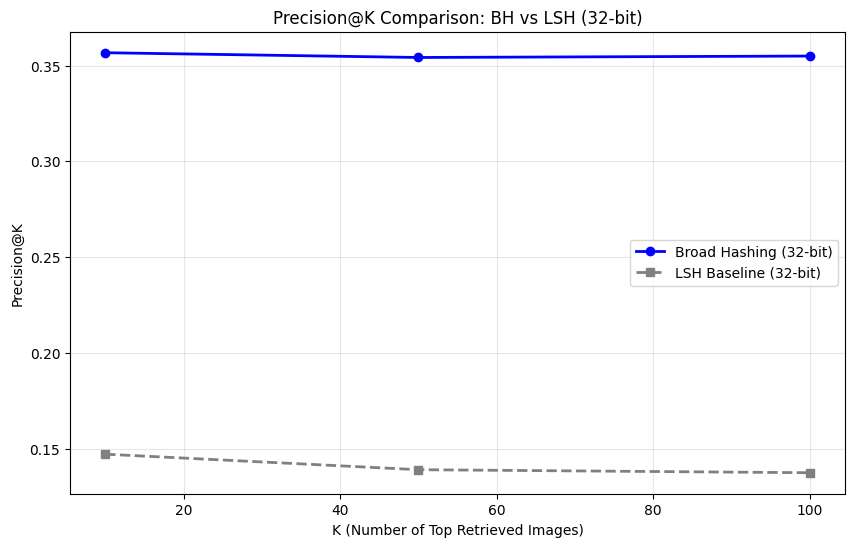

  ✓ Saved: precision_at_k_comparison_32bit.png
  Generating 64-bit Precision@K curve...


<Figure size 640x480 with 0 Axes>

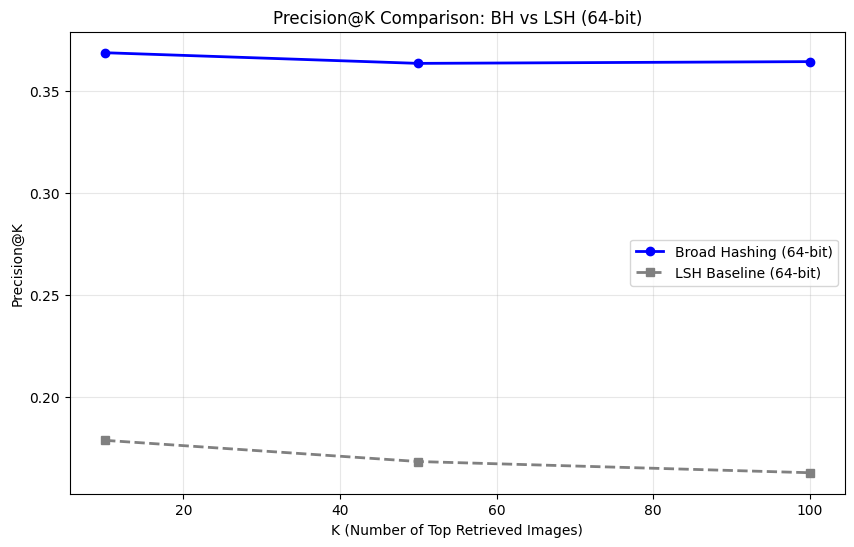

  ✓ Saved: precision_at_k_comparison_64bit.png


<Figure size 640x480 with 0 Axes>

In [10]:
#  Main Execution
if __name__ == "__main__":
    print("=" * 70)
    print(" Broad Hashing (BH) for CIFAR-10 Image Retrieval")
    
    # ===== Configuration =====
    CIFAR10_PATH = r"D:\UTM\SEM 3\Advance Data Structure\Alternative Assesment Part B\cifar-10-batches-py"
    
    # Report specifications:
    # - "approximately 1000 feature nodes and 5000 enhancement nodes"
    # - "regularization parameter set to a small value "
    # - "hash bit lengths, specifically 32 and 64 bits"
    
    # Experiment 1: 32-bit hash codes
    HASH_BITS_32 = 32
    
    # Experiment 2: 64-bit hash codes
    HASH_BITS_64 = 64
    
    # Network structure: ~1000 feature nodes, ~5000 enhancement nodes
    NUM_FEATURE_GROUPS = 10      # a = 10
    NODES_PER_GROUP = 100         # α = 100 → total feature nodes = 10×100 = 1000
    NUM_ENHANCEMENT = 5000        # c = 5000
    
    LAMBDA_REG = 2**-27              # Regularization parameter
    
    # Dataset settings 
    NUM_QUERY_SAMPLES = 1000      # "1,000 randomly selected images from test set"
    
     # Evaluation K values (as per report: top 10, 50, 100)
    K_VALUES = [10, 50, 100]
    
    print("\n[Configuration]")
    print(f"  Network: {NUM_FEATURE_GROUPS * NODES_PER_GROUP} feature + {NUM_ENHANCEMENT} enhancement nodes")
    print(f"  Evaluation metrics: mAP, Precision@K for K={K_VALUES}")
    
    # ===== Load and Preprocess Data =====
    print("[Step 1] Loading and Preprocessing CIFAR-10")
    
    X_train, y_train, X_test, y_test = load_cifar10_local(CIFAR10_PATH)
    
    X_database = (X_train.astype(np.float32) / 255.0)
    y_database = y_train
    
    np.random.seed(42)
    query_indices = np.random.choice(X_test.shape[0], NUM_QUERY_SAMPLES, replace=False)
    X_query = (X_test[query_indices].astype(np.float32) / 255.0)
    y_query = y_test[query_indices]
    
    print(f"  Database: {X_database.shape[0]} images")
    print(f"  Query: {X_query.shape[0]} images")
    
    # ===== Experiment 1: 32-bit =====
    print("\n" + "=" * 80)
    print("[Experiment 1] Training with 32-bit Hash Codes")
    print("=" * 80)
    
    # --- LSH Baseline (32-bit) ---
    print("\n[1a] LSH Baseline - 32-bit")
    print("-" * 95)
    start_lsh_32 = time.time()
    
    lsh_32 = LSH(hash_bits=HASH_BITS_32, input_dim=X_database.shape[1])
    
    print(f"  ✓ LSH initialized (no training required)")
    
    # Generate hash codes
    print(f"  Generating hash codes...")
    B_database_lsh_32 = lsh_32.predict(X_database)
    B_query_lsh_32 = lsh_32.predict(X_query)
    
    time_lsh_32 = time.time() - start_lsh_32
    print(f"  ✓ Hash code generation time: {time_lsh_32:.2f} seconds")
    
    # Evaluate
    print(f"  Evaluating retrieval performance...")
    results_lsh_32 = evaluate_retrieval(
        B_database_lsh_32, y_database,
        B_query_lsh_32, y_query,
        k_values=K_VALUES
    )
    results_lsh_32['training_time'] = time_lsh_32
    
    print(f"  ✓ LSH 32-bit - mAP: {results_lsh_32['mAP']:.4f}, P@10: {results_lsh_32['precision_at_k'][10]:.4f}")
    
    # --- Broad Hashing (32-bit) ---
    print(f"\n[1b] Broad Hashing - 32-bit")
    print("-" * 95)
    start_bh_32 = time.time()
    
    bh_32 = BroadHashing(
        num_classes=10,
        hash_bits=HASH_BITS_32,
        num_feature_groups=NUM_FEATURE_GROUPS,
        nodes_per_group=NODES_PER_GROUP,
        num_enhancement=NUM_ENHANCEMENT,
        lambda_reg=LAMBDA_REG
    )
    
    bh_32.fit(X_database, y_database)
    training_time_bh_32 = time.time() - start_bh_32
    
    print(f"\n  Generating hash codes...")
    B_database_32 = bh_32.predict(X_database)
    B_query_32 = bh_32.predict(X_query)
    
    print(f"\n  Evaluating retrieval performance...")
    results_bh_32 = evaluate_retrieval(
        B_database_32, y_database,
        B_query_32, y_query,
        k_values=K_VALUES
    )
    results_bh_32['training_time'] = training_time_bh_32
    
    print(f"  ✓ BH 32-bit - mAP: {results_bh_32['mAP']:.4f}, P@10: {results_bh_32['precision_at_k'][10]:.4f}")
    

    # ===== Experiment 2: 64-bit =====
    # --- LSH Baseline (64-bit) ---
    print("\n[2a] LSH Baseline - 64-bit")
    print("-" * 95)
    
    start_lsh_64 = time.time()
    
    lsh_64 = LSH(hash_bits=HASH_BITS_64, input_dim=X_database.shape[1])
    
    print(f"  ✓ LSH initialized (no training required)")
    
    # Generate hash codes
    print(f"  Generating hash codes...")
    B_database_lsh_64 = lsh_64.predict(X_database)
    B_query_lsh_64 = lsh_64.predict(X_query)
    
    time_lsh_64 = time.time() - start_lsh_64
    print(f"  ✓ Hash code generation time: {time_lsh_64:.2f} seconds")
    
    # Evaluate
    print(f"  Evaluating retrieval performance...")
    results_lsh_64 = evaluate_retrieval(
        B_database_lsh_64, y_database,
        B_query_lsh_64, y_query,
        k_values=K_VALUES
    )
    results_lsh_64['training_time'] = time_lsh_64
    
    print(f"  ✓ LSH 64-bit - mAP: {results_lsh_64['mAP']:.4f}, P@10: {results_lsh_64['precision_at_k'][10]:.4f}")
    
    # --- Broad Hashing (64-bit) ---
    print(f"\n[2b] Broad Hashing - 64-bit")
    print("-" * 95)
    
    start_bh_64 = time.time()
    
    bh_64 = BroadHashing(
        num_classes=10,
        hash_bits=HASH_BITS_64,
        num_feature_groups=NUM_FEATURE_GROUPS,
        nodes_per_group=NODES_PER_GROUP,
        num_enhancement=NUM_ENHANCEMENT,
        lambda_reg=LAMBDA_REG
    )
    
    bh_64.fit(X_database, y_database)
    training_time_bh_64 = time.time() - start_bh_64
    
    print(f"\n  ✓ Training completed in {training_time_bh_64:.2f} seconds")
    
    # Generate hash codes
    print(f"  Generating hash codes...")
    B_database_bh_64 = bh_64.predict(X_database)
    B_query_bh_64 = bh_64.predict(X_query)
    
    # Evaluate
    print(f"  Evaluating retrieval performance...")
    results_bh_64 = evaluate_retrieval(
        B_database_bh_64, y_database,
        B_query_bh_64, y_query,
        k_values=K_VALUES
    )
    results_bh_64['training_time'] = training_time_bh_64
    
    print(f"  ✓ BH 64-bit - mAP: {results_bh_64['mAP']:.4f}, P@10: {results_bh_64['precision_at_k'][10]:.4f}")
    
    # Display comprehensive comparison table
    print(" DETAILED Comparison Table")
    print("=" * 95)
    
    print(f"\n {'Metric':<30} | {'32-bit LSH':^15} | {'32-bit BH':^15} | {'64-bit LSH':^15} | {'64-bit BH':^15}")
    print(f" {'-'*30}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}")
    
    # mAP
    print(f" {'mAP':<30} | {results_lsh_32['mAP']:>13.4f} | {results_bh_32['mAP']:>13.4f} | {results_lsh_64['mAP']:>13.4f} | {results_bh_64['mAP']:>13.4f}")
    
    # Precision@K for all K values
    for k in K_VALUES:
        print(f" {f'Precision@{k}':<30} | {results_lsh_32['precision_at_k'][k]:>13.4f} | {results_bh_32['precision_at_k'][k]:>13.4f} | {results_lsh_64['precision_at_k'][k]:>13.4f} | {results_bh_64['precision_at_k'][k]:>13.4f}")
    
    # Training time
    print(f" {'-'*30}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}-+-{'-'*15}")
    print(f" {'Training Time (seconds)':<30} | {results_lsh_32['training_time']:>13.2f} | {results_bh_32['training_time']:>13.2f} | {results_lsh_64['training_time']:>13.2f} | {results_bh_64['training_time']:>13.2f}")
    
    # --- Performance Improvement Analysis ---
    print("\n" + "=" * 95)
    print(" PERFORMANCE IMPROVEMENT ANALYSIS (BH over LSH)")
    print("=" * 95)
    
    # Calculate improvements
    map_improvement_32 = ((results_bh_32['mAP'] - results_lsh_32['mAP']) / results_lsh_32['mAP']) * 100
    map_improvement_64 = ((results_bh_64['mAP'] - results_lsh_64['mAP']) / results_lsh_64['mAP']) * 100
    
    p10_improvement_32 = ((results_bh_32['precision_at_k'][10] - results_lsh_32['precision_at_k'][10]) / results_lsh_32['precision_at_k'][10]) * 100
    p10_improvement_64 = ((results_bh_64['precision_at_k'][10] - results_lsh_64['precision_at_k'][10]) / results_lsh_64['precision_at_k'][10]) * 100
    
    print(f"\n 32-bit Hash Codes:")
    print(f"   mAP Improvement:        {map_improvement_32:>+7.2f}%")
    print(f"   Precision@10 Improvement: {p10_improvement_32:>+7.2f}%")
    
    print(f"\n 64-bit Hash Codes:")
    print(f"   mAP Improvement:        {map_improvement_64:>+7.2f}%")
    print(f"   Precision@10 Improvement: {p10_improvement_64:>+7.2f}%")
    
    # --- Training Efficiency Analysis ---
    print("\n" + "=" * 95)
    print(" TRAINING EFFICIENCY ANALYSIS")
    print("=" * 95)
    
    print(f"\n LSH (Data-Independent - No Training):")
    print(f"   32-bit generation time: {results_lsh_32['training_time']:>8.2f} seconds")
    print(f"   64-bit generation time: {results_lsh_64['training_time']:>8.2f} seconds")
    
    print(f"\n BH (Data-Dependent - Requires Training):")
    print(f"   32-bit training time:   {results_bh_32['training_time']:>8.2f} seconds")
    print(f"   64-bit training time:   {results_bh_64['training_time']:>8.2f} seconds")
    
    # --- Visualization ---
    print("\n" + "=" * 95)
    print(" GENERATING VISUALIZATION")
    print("=" * 95)
    
    # Plot 32-bit comparison
    print("\n  Generating 32-bit Precision@K curve...")
    plot_comparative_curves(results_lsh_32, results_bh_32, bit_length=32)
    plt.savefig('precision_at_k_comparison_32bit.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: precision_at_k_comparison_32bit.png")
    
    # Plot 64-bit comparison
    print(f"  Generating 64-bit Precision@K curve...")
    plot_comparative_curves(results_lsh_64, results_bh_64, bit_length=64)
    plt.savefig('precision_at_k_comparison_64bit.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: precision_at_k_comparison_64bit.png")
    